# Activity 5.1 Neural Network

(Last Modified September 4th 2023)

This Laboratory activity should take approximately two hours to complete.

## Learning Outcomes

In this activity you will learn to:
- Implement a simple three layer Neural Network for the classification classification problem
- Explore the effect of initialization on model selection. 


## Prerequisites

- Lecture 9
- Module 3

# Linearly Separable Classes
## Synthetic Data Generation 
Here we follow an approach similar to what we took to produce the datasets for classification problems in Module 3.

In [5]:
from Activity5 import make_gaussian_mixture_data
import numpy as np

## Generative parameters
c0 = 0; c1 = 1 # class labels
mu0 = [4.5, 0.5]; p0 = 0.60
mu1 = [1.0, 4.0]; p1 = 1 - p0
sigma =  np.eye(2) # shared covariance matrix
sigma0 = sigma;   sigma1 = sigma

covs = np.array([sigma0, sigma1])
means = np.array([mu0, mu1])
class_probs = np.array([p0, p1])

random_state = 123
n = 100

X, y = make_gaussian_mixture_data(n=n, means=means, covs=covs, class_probs=class_probs, random_state=random_state)

N0 = np.sum(y==0)
N1 = n - N0

ModuleNotFoundError: No module named 'Activity5'

In [6]:
import matplotlib.pyplot as plt
from Activity5 import plot_scatter_by_label

plot_scatter_by_label(X=X, y=y)

ModuleNotFoundError: No module named 'Activity5'

## Neural Network
In this example we implement a simple 3-layer (i.e., the input layer, one hidden layer and the output layer) network with sigmoid as the activation function. 

Note that the implementation below is not a modular implementation (i.e. it is only for a 3-layer neural network with a sigmoid activation), a good exercise would be to think how to modularize this implementation to any number of hidden layers and any type of activations.

### Auxiliary Functions
We need to define some auxiliary functions. In particular, we need to implement an activation function `h` and its derivitive `h_d`. Finally, we implement `accuracy` function that calculates the accuracy percentage.


### Task A: Activation Function

Use the chain rule to compute the derivative of the activation function and then implement a to compute it.

In [7]:
# auxiliary functions 
## the activation function (sigmoid here)
def h(z):
    return (1/(1+np.exp(-3*z)))

## the derivitive of the activation function (sigmoid here)
def h_d(z):
    return (h(z)*(1-h(z)))

## Accuracy
def accuracy(pred, label):
    return (pred == label).mean()

### Name Conventions
We choose variable names to be close to the math terms in Chapter 2. Form now on, `N` referes to the number of training data. `X1` and `T1` indicate to train data and labels, while `X2` and `T2` refer to test data and labels, respectively.

`Wn` and `bn` are refereing to weight matrix and bias term for layer `n` (here `n` is either `1` or `2`), and `_d` stands for delta. Finally, `an` and `zn` are denoting the total weighted sum activation and its activation value (here `n` is in `[0:2]`).

The following code splits the data sample into a train and test split using the names described above.

In [8]:
from sklearn.model_selection import train_test_split

train_size=0.5
X1, X2, T1, T2 = train_test_split(X, y, train_size=train_size, random_state=random_state)
N = X1.shape[0]
D = X1.shape[1]

T1 = T1.reshape(-1, 1)
T2 = T2.reshape(-1, 1)

N, D

NameError: name 'X' is not defined

### Feedforward Function
The following function perform one feedforward pass for a 3-layer feedforward network. We will call this function in a loop to train our network.

In each layer we are taking a linear combination of a nonlinear transformation on the data, which is then fed into the next layer. 

The full transformation we are applying is:
\begin{equation}
z_3 = a_2 W_2 + b_2
\end{equation}

\begin{equation}
a_3 = h(z_3)
\end{equation}

Where

\begin{equation}
a_2 = h(z_2)
\end{equation}

\begin{equation}
z_2 = a_1 W_1 + b_1
\end{equation}

and 

\begin{equation}
a_1 = X_i
\end{equation}

### Task B: Feedforward

Complete the feedforward function below using the transformations described above.

In [9]:
def feedforward(Xi, Ti, W1, b1, W2, b2):
    ### 1st (input) layer 
    a1 = Xi                           
    y = Ti                          
    ### 2nd (hidden) layer
    z2 = a1 @ W1 + b1                            
    a2 = h(z2)                                  
    ### 3rd (output) layer
    z3 = a2 @ W2 + b2                         
    a3 = h(z3)                            
    return(a1, a2, a3, y, z2, z3)

### Backpropagation Function
The following function performs one backpropagation pass for a 3-layer feedforward network. We will call this function after each feedforward step..

We make use of the chain rule to calculate an update value for our weight vectors. 

\begin{equation}
d_3 = -(T_i-a_3)\frac{dh}{dz}(z_3)
\end{equation}

\begin{equation}
d_2 =  d_3 W_2^T \frac{dh}{dz}(z2)                          
\end{equation}


### Task C: Backpropagation

Complete the Backpropagation function below using the transformations described above.

In [10]:
def backpropagation(Ti, W2, z2, z3, a3):
    ### 3rd (output) layer
    d3 = -(Ti-a3) * h_d(z3)                          
    ### 2nd (hidden) layer
    d2 =  (d3 @ W2.T) * h_d(z2)                          
    return(d2,d3)


**Note 1:** Since the output of our neural network is the probability of class `c1`, we classify the points with any probability larger than `0.5` as a member of `c1`. All the other points will be labeled as `c0`. `c1` and `c0` in our case are `1` and `0` respectively.

In [4]:
# one more aux functions before we start
def prediction(X, W1, W2, b1, b2, threshold=0.5):
    # we use the feedforward network we defined to obtain output activation (a3), we don't care about the
    # rest so we use _ to store them. We also don't need to send T so we just send 1 instead
    _,_, a3,_,_,_ = feedforward(X, 1,W1,b1, W2, b2)
    return np.array([1 if above_thresh else 0 for above_thresh in (a3 >= threshold)]).reshape(-1,1)
    

### Initialization
Like any other algorithms, NN starts with some parameter settings and initializations. Here, `K` indicates the number of units (neurons) in the hidden layer.

In [8]:
# Setting parameters
K = 3 # number of units in the hidden layer
epoch_max = 1000 # maximum number of iterations
eta = 0.1 # learning rate
alpha = 0.0001 # regularization term

# initialization
epoch = 1 # epoch (iteration) counter
terminate = False   # termination criteria

## weight vectors/matrices initialization
### w stands for weight and b for bias
### the number after the letters indicates the layer number
W1 = np.random.normal(scale=0.5, size=(D,K)) * 0.01
b1 = np.zeros((1,K))
W2 = np.random.normal(scale=0.5, size=(K,1)) * 0.01
b2 = np.zeros((1,1))
## tracing accuracy of the model 
train_accuracy = []

### Main Loop
Now it's time to iteratively run the feed-forward and back-propagation passes.

### Task D: Training Loop

Use the feedforward and backpropagation functions to complete the training loop below. Use the output of these functions to compute updates to the weight and bias terms of each layer. 

In [9]:
# main loop
while (not terminate):
    
    ## delta vectors/matrices initialization (for batch backpropagation)
    ### _d stands for delta - we use zeros_like function to maintain the dimensions
    W1_d = np.zeros_like(W1)
    b1_d = np.zeros_like(b1)
    W2_d = np.zeros_like(W2)
    b2_d = np.zeros_like(b2)
    
    ## inner loop for each train sample (do we really need this loop or can we use vectorized notation)
    # try to remove this loop and you will get a significant speed up
    for i in range(N):
        ## Feedforward:
        a1, a2, a3, y, z2, z3 = feedforward(X1[i,None], T1[i], W1, b1, W2, b2)

        ## Backpropagation:
        d2, d3 = backpropagation(T1[i], W2, z2, z3, a3)

        ## calculate the delta values
        ### 1st layer
        W1_d = W1_d + a1.T @ d2
        b1_d = b1_d + d2
        ### 2nd layer
        W2_d = W2_d + a2.T @ d3
        b2_d = b2_d + d3


    
    ## update weight vectors and matrices
    ### 1st (input) layer
    W1 = W1 - eta * (W1_d/N + alpha*W1)
    b1 = b1 - eta * (b1_d/N)
    ### 2nd (hidden) layer
    W2 = W2 - eta * (W2_d/N + alpha*W2)
    b2 = b2 - eta * (b2_d/N)

    ## trace train accuracy
    train_accuracy.append(accuracy(prediction(X1, W1, W2, b1, b2), T1))
    
    ## increase the iteration counter
    epoch = epoch + 1
    
    ## check the termination criteria
    if (epoch >= epoch_max) or train_accuracy[-1]==1: terminate = True
print('Done!')

Done!


### Evaluation
Let's visualize the classification accuracy trend as the training goes on:

Text(0.5, 1.0, 'Training Accuracy during training')

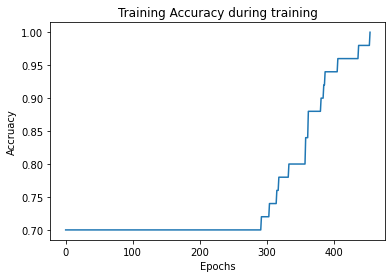

In [10]:
## Train Accuracy
plt.plot(train_accuracy)
plt.xlabel('Epochs')
plt.ylabel('Accruacy')
plt.title('Training Accuracy during training')

# Linearly Non-separable Classes
## Synthetic Data Generation 
The dataset we generated for the previous experiemnts is rather easily separable using a linear model. One can modify the data generator code and repeat the experiments on more difficult samples (i.g., closer $\mu$, non-shared and identical $\Sigma$, or very imbalanced class sizes). Another approach to challenge our NN is to apply it on linearly non-separable classes where at least one of the classes is multi-modal (like two or more separate islands). The code below produces this sort of data.

<AxesSubplot:title={'center':'Gaussian Mixture'}, xlabel='X0', ylabel='X1'>

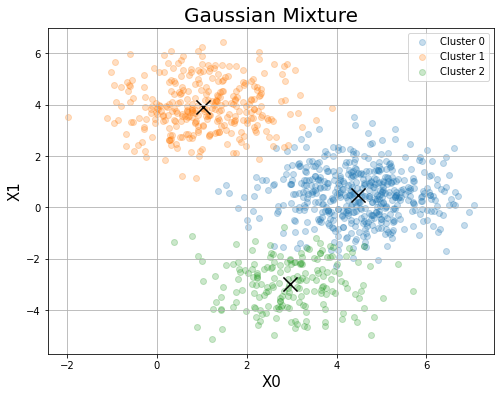

In [11]:
# Set the parameters:
n2 = 1000 # number of samples
K = 3    # number of clusters
D = 2    # number of dimensions

# Initializations:
# Psi(k) indicates the fraction of samples that are from cluster k
Psi = np.array([0.5,0.3,0.2]) 
# initiate  the effective number of points assigned to each cluster
Nk = np.zeros(K,dtype='int')    
# initiate the centriods (means) of the clusters (randomly chosen)
Mu = np.array([[4.5,0.5],[1,4],[3,-3]])
# initiate the covariance matrices   
Sigma = np.array([np.eye(D) for _ in range(K)])

X, y = make_gaussian_mixture_data(n=n2, means=Mu, covs=Sigma, class_probs=Psi, random_state=random_state)

# Generate data:
feat_names= ['x%d'%(i+1) for i in range(D)]

plot_scatter_by_label(X, y)

In [12]:
train_size=0.5
X1, X2, T1, T2 = train_test_split(X, y, train_size=train_size, random_state=random_state)
N = X1.shape[0]
D = X1.shape[1]

T1 = T1.reshape(-1, 1)
T2 = T2.reshape(-1, 1)

N, D

(500, 2)

Now, we can repeat the above experiments on this linearly non-separable dataset. However, let's first put the pieces of the above code togather to define a function which trains a 3-layer NN with `K` units in the hiden layer, and returns the training and testing accuracies.

In [13]:
def NN(K, X1, T1, X2, T2, epoch_max=500, seed=None):
    if seed is not None: np.random.seed(seed)
    # Setting parameters
    eta = 0.1 # learning rate
    alpha = 0.0001 # regularization term
    N,D = X1.shape

    # initialization
    epoch = 1 # epoch (iteration) counter
    terminate = False   # termination criteria

    ## weight vectors/matrices initialization
    ### w stands for weight and b for bias
    ### the numbers after the letters indicates the layer number
    W1 = np.random.normal(scale=0.5, size=(D,K)) * 0.01
    b1 = np.zeros((1,K))
    W2 = np.random.normal(scale=0.5, size=(K,1)) * 0.01
    b2 = np.zeros((1,1))
    ## tracing accuracy of the model 
    train_accuracy = []
    test_accuracy = []
    
    # main loop
    while (not terminate):

        # note that this is the vectorised implementaion so it slightly differs from the above implementation
        # try to spot and rationalize the differences.
        ## Feedforward:
        a1, a2, a3, y, z2, z3 = feedforward(X1, T1, W1, b1, W2, b2)

        ## Backpropagation:
        d2, d3 = backpropagation(T1, W2, z2, z3, a3)

        ## calculate the delta values
        ### 1st layer
        W1_d = a1.T @ d2
        b1_d = d2
        ### 2nd layer
        W2_d = a2.T @ d3
        b2_d = d3

        ## update weight vectors and matrices
        ### 1st (input) layer
        W1 = W1 - eta * (W1_d/N + alpha*W1)
        b1 = b1 - eta * (b1_d.mean(axis=0, keepdims=True))
        ### 2nd (hidden) layer
        W2 = W2 - eta * (W2_d/N + alpha*W2)
        b2 = b2 - eta * (b2_d.mean(axis=0, keepdims=True))

        ## trace train  and test accuracy
        train_accuracy.append(accuracy(prediction(X1, W1, W2, b1, b2), T1))
        test_accuracy.append(accuracy(prediction(X2, W1, W2, b1, b2), T2))
        ## increase the iteration counter
        epoch = epoch + 1

        ## check the termination criteria
        if (epoch >= epoch_max): terminate = True
        
    return (train_accuracy,test_accuracy)


Now we train our network and plot the training accuracy.

In [14]:
train,test = NN(3,X1, T1, X2, T2, epoch_max = 2500)

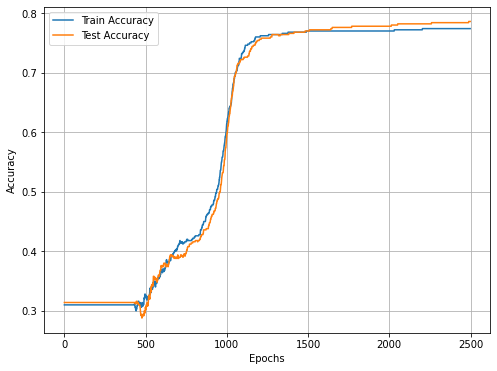

In [15]:
fig, axs = plt.subplots(1, 1)
fig.set_figwidth(8)
fig.set_figheight(6)

axs.plot(range(len(train)), train, label='Train Accuracy')
axs.plot(range(len(test)), test, label='Test Accuracy')
axs.set_xlabel('Epochs')
axs.set_ylabel('Accuracy')
axs.grid()
axs.legend()

## Model Selection
In Modules 2 and 3 we learned that models may have different levels of generalization according to their complexities. We also know that the number of units in the hidden layer has a direct effect on the model complexity. Therefore, we intend to study the effect of the hidden layer size on the neural network performance. To perform such study, we repeat the above experiment several times (every time with a different subset of training samples) for different values of `neuron_count`. Then, we draw a boxplot to show the results.

### Task E: Hyperparameter Sweep

Complete the function below which tests a range of neurons in the hidden layer, accross a number of repetitions of random data samples, and returns the train and test accuracy in a 3 dimensional matrix. 

In [36]:
def hyperparam_sweep(neuron_count, reps, n, epoch_max):
    res = np.zeros(shape=(len(neuron_count), reps, 2))
    for i, k in enumerate(neuron_count):
        for j in range(reps):
            print('neurons={0}, rep={1}, '.format(k, j), end='')

            X1, T1 = make_gaussian_mixture_data(n=n, means=Mu, covs=Sigma, class_probs=Psi, random_state=None)
            X2, T2 = make_gaussian_mixture_data(n=n, means=Mu, covs=Sigma, class_probs=Psi, random_state=None)

            T1 = T1.reshape(-1, 1)
            T2 = T2.reshape(-1, 1)

            train, test = NN(k, X1, T1, X2, T2, epoch_max=600)

            print('train={0}, test={1}'.format(train[-1], test[-1]))

            res[i, j, :] = np.array([train[-1], test[-1]])
    return res

neuron_count = [5,10,50,100]
reps = 5
n = 1000

epoch_max = 600
res = hyperparam_sweep(neuron_count=neuron_count, reps=reps, n=n, epoch_max=epoch_max)

neurons=5, rep=0, train=0.456, test=0.5
neurons=5, rep=1, train=0.472, test=0.451
neurons=5, rep=2, train=0.522, test=0.514
neurons=5, rep=3, train=0.453, test=0.411
neurons=5, rep=4, train=0.468, test=0.47
neurons=10, rep=0, train=0.533, test=0.56
neurons=10, rep=1, train=0.574, test=0.558
neurons=10, rep=2, train=0.573, test=0.556
neurons=10, rep=3, train=0.557, test=0.581
neurons=10, rep=4, train=0.511, test=0.533
neurons=50, rep=0, train=0.607, test=0.614
neurons=50, rep=1, train=0.597, test=0.587
neurons=50, rep=2, train=0.639, test=0.637
neurons=50, rep=3, train=0.66, test=0.651
neurons=50, rep=4, train=0.631, test=0.629
neurons=100, rep=0, train=0.654, test=0.632
neurons=100, rep=1, train=0.644, test=0.67
neurons=100, rep=2, train=0.655, test=0.659
neurons=100, rep=3, train=0.624, test=0.624
neurons=100, rep=4, train=0.629, test=0.622


### Task F: Model Selection

Plot the train and test accuracy over the neuron choices used above. Include error bars which describe a 95% confidence interval. 

Text(0.5, 1.0, 'Accuracy vs Number of Neurons in Hidden Layer')

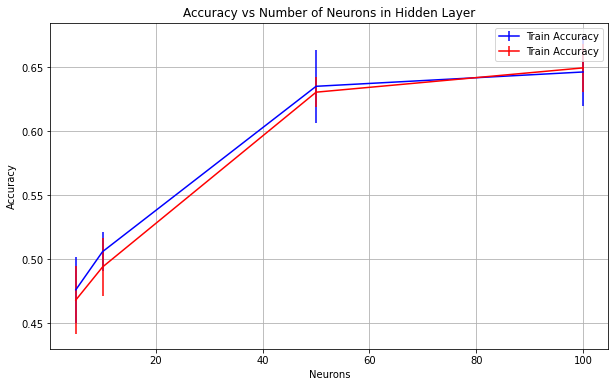

In [34]:
fig, axs = plt.subplots(1, 1)
fig.set_figheight(6)
fig.set_figwidth(10)
res.shape

mu_s = res.mean(axis=1)
ste_s = 1.96*res.std(axis=1)/np.sqrt(reps)

axs.errorbar(x=neuron_count, y=mu_s[:, 0], yerr=ste_s[:, 0], label='Train Accuracy', c='b')
axs.errorbar(x=neuron_count, y=mu_s[:, 1], yerr=ste_s[:, 1], label='Train Accuracy', c='r')
axs.legend()
axs.grid()
axs.set_xlabel('Neurons')
axs.set_ylabel('Accuracy')
axs.set_title('Accuracy vs Number of Neurons in Hidden Layer')